Fitting 5 folds for each of 24 candidates, totalling 120 fits
En iyi parametreler: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Doğruluk (Accuracy): 0.8792
ROC AUC Skoru: 0.7558
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.65      0.12      0.21       933
           1       0.88      0.99      0.93      6359

    accuracy                           0.88      7292
   macro avg       0.77      0.56      0.57      7292
weighted avg       0.85      0.88      0.84      7292



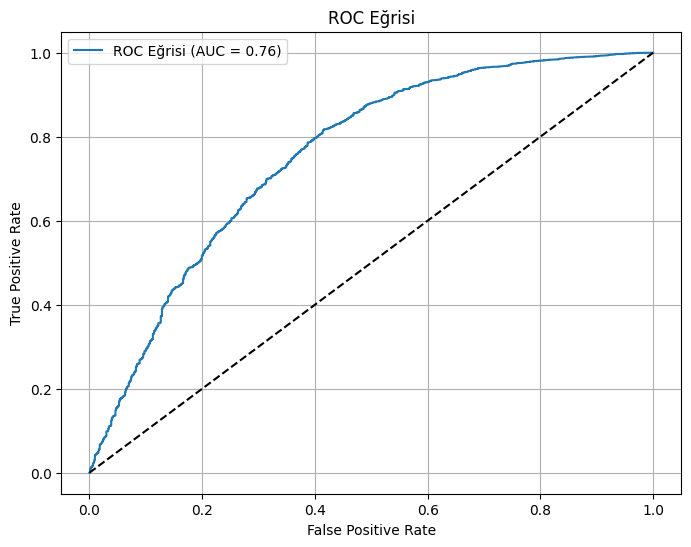

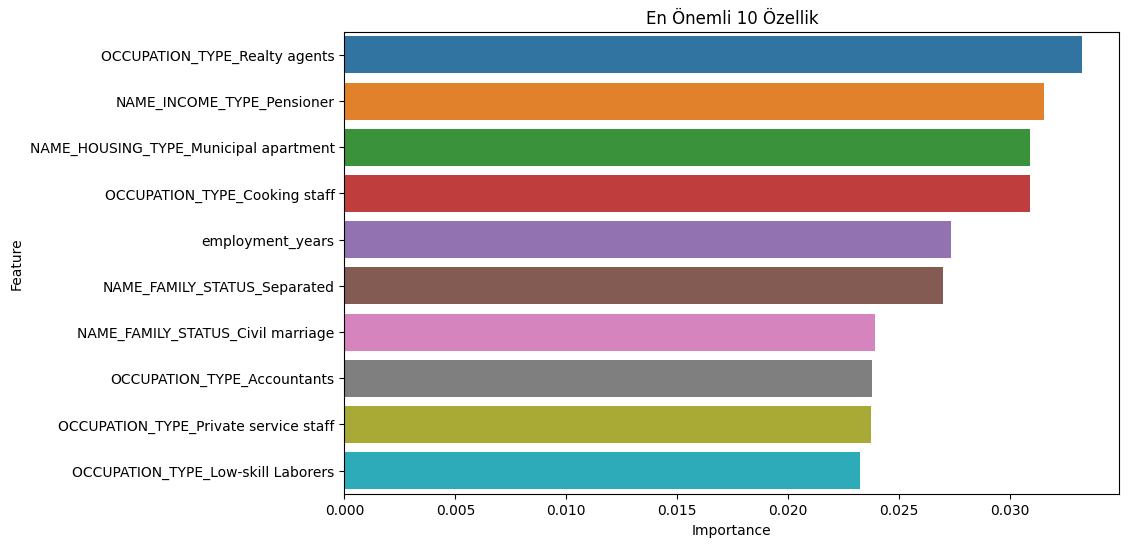

Model 'credit_approval_model.pkl' olarak kaydedildi.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Veri setlerini yükleme
application_record = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')
credit_record = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')

# Hedef değişken oluşturma: Ödeme geçmişine göre onay/red
# STATUS: 'C' (ödendi), '0-5' (gecikme), 'X' (kredi yok). 'C' ve 'X' hariç diğer durumlar riskli kabul edilir.
credit_record['target'] = credit_record['STATUS'].apply(lambda x: 0 if x in ['C', 'X'] else 1)
# Her ID için maksimum risk değerini al (en az bir gecikme varsa riskli)
target_df = credit_record.groupby('ID')['target'].max().reset_index()

# Veri setlerini birleştirme
data = pd.merge(application_record, target_df, on='ID', how='inner')

# Gereksiz sütunları kaldırma
data = data.drop(['ID'], axis=1)

# Özellik mühendisliği: Yeni özellikler ekleme
data['income_to_age'] = data['AMT_INCOME_TOTAL'] / (data['DAYS_BIRTH'] / -365)  # Gelir/Yaş oranı
data['employment_years'] = data['DAYS_EMPLOYED'].apply(lambda x: -x / 365 if x < 0 else 0)

# Bağımlı ve bağımsız değişkenleri ayırma
X = data.drop('target', axis=1)
y = data['target']

# Kategorik ve sayısal sütunları belirleme
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ön işleme pipeline'ları
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Model pipeline'ı (XGBoost ile)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hiperparametre optimizasyonu
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_model = grid_search.best_estimator_
print(f"En iyi parametreler: {grid_search.best_params_}")

# Tahmin yapma
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Model değerlendirme
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"ROC AUC Skoru: {roc_auc:.4f}")
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# ROC Eğrisi çizimi
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Eğrisi (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Özellik önem sıralaması (Feature Importance)
feature_names = (numerical_cols + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_cols).tolist())
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('En Önemli 10 Özellik')
plt.show()

# Modeli kaydetme
joblib.dump(best_model, 'credit_approval_model.pkl')
print("Model 'credit_approval_model.pkl' olarak kaydedildi.")